![Egeria Logo](https://raw.githubusercontent.com/odpi/egeria/master/assets/img/ODPi_Egeria_Logo_color.png)

### ODPi Egeria Hands-On Lab
# Welcome to the Conformance Test Suite Lab

## Introduction

ODPi Egeria is an open source project that provides open standards and implementation libraries to connect tools, catalogs and platforms together so they can share information (called metadata) about data and the technology that supports it.

In this hands-on lab you will get a chance to work with the conformance test suite that is used to validate that a technology can successfully join an open metadata repository cohort.

## About the Conformance Suite 

The Conformance Suite can be used to test a Platform or Repository Connector to record which Conformance 
Profiles it supports. The Conformance Suite has different Workbenches that are used to test different types of 
system. 

Initially our focus will be on the Repository Conformance Workbench. This workbench is used to test that an 
OMRS Repository Connector record which of the Repository Conformance Profiles it supports.

There are 13 repository conformance profiles in this workbench. One of them is mandatory - i.e. any repository
connector must fully support that profie in order to be certified as conformant. The other profiles are optional and 
for each of these optional profiles, a repository connector can be certified as compliant even if it does not 
provide the function required by that profile - so long as it responds appropriately to requests.


## Configuring and running the Conformance Suite 

We'll come back to the profiles later, but for now let's configure and run the Conformance Suite.

We're going to need a pair of OMAG Servers - one to run the repository under test, the other to run the workbench. The servers need to join the same cohort.

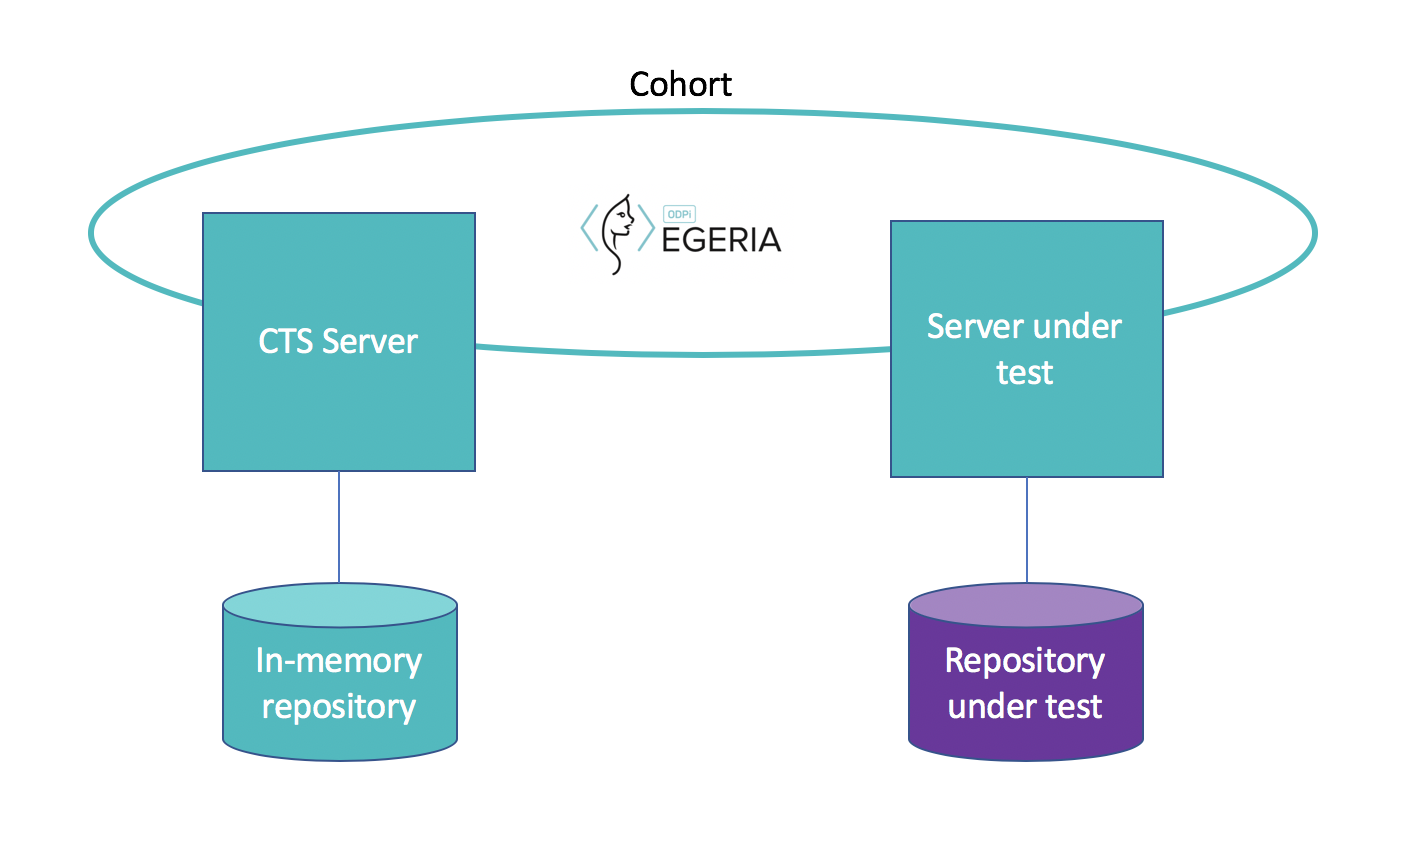

When the one runnng the workbench sees the cohort registration of the server under test, it runs the workbench tests against that server's repository.

## Starting up the Egeria platforms

We'll start one OMAG Server Platform on which to run both the servers.
We also need Apache Zookeeper and Apache Kafka.  


In [1]:
import requests
import pprint
import json
import os

ctsPlatformURL     = os.environ.get('ctsPlatformURL','http://localhost:8080') 


def checkServerPlatform(testPlatformName, testPlatformURL):
    response = requests.get(testPlatformURL + "/open-metadata/platform-services/users/garygeeke/server-platform/origin/")
    if response.status_code == 200:
        print("   ...", testPlatformName, "at", testPlatformURL, "is active - ready to begin")
    else:
        print("   ...", testPlatformName, "at", testPlatformURL, "is down - start it before proceeding")

print ("\nChecking OMAG Server Platform availability...")
checkServerPlatform("CTS OMAG Server Platform", ctsPlatformURL)

print ("Done.")


Checking OMAG Server Platform availability...
   ... CTS OMAG Server Platform at http://localhost:8080 is active - ready to begin
Done.


## Configuring the Servers

We're going to configure both the servers in the diagram above.

It's useful to create some generally useful definitions here.

Knowing both server names up front will be handy for when we configure the workbench.

To configure the servers we'll need a common cohort name and event bus configuration. 
We can leave the server to default to using a local in-memory repository.
The CTS server does not need to run any Access Services.

In [2]:
ctsServerName     = "CTS_Server"
sutServerName     = "SUT_Server"

#organizationName = "Coco Pharmaceuticals"
#serverType       = "Open Metadata Server"
cocoCohort       = "cocoCohort"

In [3]:
eventBusURLroot   = os.environ.get('eventBusURLroot', 'localhost:9092')

jsonContentHeader = {'content-type':'application/json'}
eventBusBody      = {
    "producer": {
        "bootstrap.servers": eventBusURLroot
    },
    "consumer":{
        "bootstrap.servers": eventBusURLroot
    }
}

We can also define a userId for the configuration commands. You could change this to a name you choose.

In [4]:
adminUserId      = "garygeeke"

We can perform configuration operations through the administrative interface provided by the ctsPlatformURL.

The URLs for the configuration REST APIs have a common structure and begin with the following root:

In [5]:
adminPlatformURL = ctsPlatformURL

In [6]:
adminCommandURLRoot = adminPlatformURL + '/open-metadata/admin-services/users/' + adminUserId + '/servers/'

What follows are descriptions and coded requests to configure each server.  There are a lot of common steps 
involved in configuring a metadata server, so we first define some simple 
functions that can be re-used in later steps for configuring each server.

In [7]:
def postAndPrintResult(url, json=None, headers=None):
    print("   ...... (POST", url, ")")
    response = requests.post(url, json=json, headers=headers)
    print("   ...... Response: ", response.json())
    
def getAndPrintResult(url, json=None, headers=None):
    print("   ...... (GET", url, ")")
    response = requests.get(url, json=json, headers=headers)
    print("   ...... Response: ", response.json())

def getResult(url, json=None, headers=None):
    print("   ...... (GET", url, ")")
    response = requests.get(url, json=json, headers=headers)
    return response.json()

def configurePlatformURL(serverName, serverPlatform):
    print("   ... configuring the platform the server will run on...")
    url = adminCommandURLRoot + serverName + '/server-url-root?url=' + serverPlatform
    postAndPrintResult(url)

#def configureMaxPageSize(serverName, maxPageSize):
#    print ("   ... configuring the maximum page size...")
#    url = adminCommandURLRoot + serverName + '/max-page-size?limit=' + maxPageSize
#    postAndPrintResult(url)

def configureServerType(serverName, serverType):
    print ("   ... configuring the server's type...")
    url = adminCommandURLRoot + serverName + '/server-type?typeName=' + serverType
    postAndPrintResult(url)

#def configureOwningOrganization(serverName, organizationName):
#    print ("   ... configuring the server's owning organization...")
#    url = adminCommandURLRoot + serverName + '/organization-name?name=' + organizationName
#    postAndPrintResult(url)

def configureUserId(serverName, userId):
    print ("   ... configuring the server's userId...")
    url = adminCommandURLRoot + serverName + '/server-user-id?id=' + userId
    postAndPrintResult(url)

def configurePassword(serverName, password):
    print ("   ... configuring the server's password (optional)...")
    url = adminCommandURLRoot + serverName + '/server-user-password?password=' + password
    postAndPrintResult(url)

#def configureSecurityConnection(serverName, securityBody):
#    print ("   ... configuring the server's security connection...")
#    url = adminCommandURLRoot + serverName + '/security/connection'
#    postAndPrintResult(url, json=securityBody, headers=jsonContentHeader)

def configureMetadataRepository(serverName, repositoryType):
    print ("   ... configuring the metadata repository...")
    url = adminCommandURLRoot + serverName + '/local-repository/mode/' + repositoryType
    postAndPrintResult(url)

def configureDescriptiveName(serverName, collectionName):
    print ("   ... configuring the short descriptive name of the metadata stored in this server...")
    url = adminCommandURLRoot + serverName + '/local-repository/metadata-collection-name/' + collectionName
    postAndPrintResult(url)

def configureEventBus(serverName, busBody):
    print ("   ... configuring the event bus for this server...")
    url = adminCommandURLRoot + serverName + '/event-bus'
    postAndPrintResult(url, json=busBody, headers=jsonContentHeader)

def configureCohortMembership(serverName, cohortName):
    print ("   ... configuring the membership of the cohort...")
    url = adminCommandURLRoot + serverName + '/cohorts/' + cohortName
    postAndPrintResult(url)
    
def configureRepositoryWorkbench(serverName, tutServerName):
    print ("   ... configuring the repository workbench for this server...")
    url = adminCommandURLRoot + serverName + '/conformance-suite-workbenches/repository-workbench/repositories/' + tutServerName
    postAndPrintResult(url)

#def configureAccessService(serverName, accessService, accessServiceOptions):
#    print ("   ... configuring the access services for this server...")
#    url = adminCommandURLRoot + serverName + '/access-services/' + accessService
#    postAndPrintResult(url, json=accessServiceOptions, headers=jsonContentHeader)

## Configuring the CTS Server

We're going to the CTS Server from the diagram above. The CTS Server is the one that runs the repository workbench.

The server will default to using a local in-memory repository.
The CTS server does not need to run any Access Services.

Notice that when We configure the CTS Server to run the repository workbench, we provide the name of the server under test.

In [8]:
ctsServerType          = "Conformance Suite Server"
ctsServerUserId        = "CTS1npa"
ctsServerPassword      = "CTS1passw0rd"
ctsServerPlatform      = ctsPlatformURL


print("Configuring " + ctsServerName + "...")

configurePlatformURL(ctsServerName, ctsServerPlatform)
#configureMaxPageSize(mdrServerName, maxPageSize)
configureServerType(ctsServerName, ctsServerType)
#configureOwningOrganization(mdrServerName, organizationName)
configureUserId(ctsServerName, ctsServerUserId)
configurePassword(ctsServerName, ctsServerPassword)
#configureSecurityConnection(ctsServerName, serverSecurityConnectionBody)
#configureMetadataRepository(ctsServerName, metadataRepositoryType)
#configureDescriptiveName(ctsServerName, metadataCollectionName)
configureEventBus(ctsServerName, eventBusBody)
configureCohortMembership(ctsServerName, cocoCohort)
configureRepositoryWorkbench(ctsServerName, sutServerName)

print("\nDone.")

Configuring CTS_Server...
   ... configuring the platform the server will run on...
   ...... (POST http://localhost:8080/open-metadata/admin-services/users/garygeeke/servers/CTS_Server/server-url-root?url=http://localhost:8080 )
   ...... Response:  {'relatedHTTPCode': 200}
   ... configuring the server's type...
   ...... (POST http://localhost:8080/open-metadata/admin-services/users/garygeeke/servers/CTS_Server/server-type?typeName=Conformance Suite Server )
   ...... Response:  {'relatedHTTPCode': 200}
   ... configuring the server's userId...
   ...... (POST http://localhost:8080/open-metadata/admin-services/users/garygeeke/servers/CTS_Server/server-user-id?id=CTS1npa )
   ...... Response:  {'relatedHTTPCode': 200}
   ... configuring the server's password (optional)...
   ...... (POST http://localhost:8080/open-metadata/admin-services/users/garygeeke/servers/CTS_Server/server-user-password?password=CTS1passw0rd )
   ...... Response:  {'relatedHTTPCode': 200}
   ... configuring the

 ## Configuring the SUT Server (Server Under Test)

We're going to the SUT Server from the diagram above. The SUT Server is the one that hosts the repository that is being tested. The SUT Server will run on the same platform as the CTS Server.

The server will default to using a local in-memory repository.
The CTS server does not need to run any Access Services.

Notice that when we configure the CTS Server to run the repository workbench, we provide the name of the server under test.

In [9]:
sutServerType          = "Metadata Repository Server"
sutServerUserId        = "SUTnpa"
sutServerPassword      = "SUTpassw0rd"
metadataCollectionName  = "SUT_MDR"
metadataRepositoryType = "in-memory-repository"

print("Configuring " + sutServerName + "...")

configurePlatformURL(sutServerName, ctsServerPlatform)
#configureMaxPageSize(mdrServerName, maxPageSize)
configureServerType(sutServerName, sutServerType)
#configureOwningOrganization(mdrServerName, organizationName)
configureUserId(sutServerName, sutServerUserId)
configurePassword(sutServerName, sutServerPassword)
#configureSecurityConnection(ctsServerName, serverSecurityConnectionBody)
configureMetadataRepository(sutServerName, metadataRepositoryType)
configureDescriptiveName(sutServerName, metadataCollectionName)
configureEventBus(sutServerName, eventBusBody)
configureCohortMembership(sutServerName, cocoCohort)

print("\nDone.")

Configuring SUT_Server...
   ... configuring the platform the server will run on...
   ...... (POST http://localhost:8080/open-metadata/admin-services/users/garygeeke/servers/SUT_Server/server-url-root?url=http://localhost:8080 )
   ...... Response:  {'relatedHTTPCode': 200}
   ... configuring the server's type...
   ...... (POST http://localhost:8080/open-metadata/admin-services/users/garygeeke/servers/SUT_Server/server-type?typeName=Metadata Repository Server )
   ...... Response:  {'relatedHTTPCode': 200}
   ... configuring the server's userId...
   ...... (POST http://localhost:8080/open-metadata/admin-services/users/garygeeke/servers/SUT_Server/server-user-id?id=SUTnpa )
   ...... Response:  {'relatedHTTPCode': 200}
   ... configuring the server's password (optional)...
   ...... (POST http://localhost:8080/open-metadata/admin-services/users/garygeeke/servers/SUT_Server/server-user-password?password=SUTpassw0rd )
   ...... Response:  {'relatedHTTPCode': 200}
   ... configuring the

The commands below deploy the server configuration documents to the server platforms where the
servers will run.

In [10]:
def deployServerToPlatform(serverName, platformURL):
    print("   ... deploying", serverName, "to the", platformURL, "platform...")
    url = adminCommandURLRoot + serverName + '/configuration/deploy'
    platformTarget = {
        "class": "URLRequestBody",
        "urlRoot": platformURL
    }
    postAndPrintResult(url, json=platformTarget, headers=jsonContentHeader)

print("\nDeploying server configuration documents to appropriate platforms...")
    
deployServerToPlatform(ctsServerName, ctsPlatformURL)
deployServerToPlatform(sutServerName, ctsPlatformURL)

print("\nDone.")


Deploying server configuration documents to appropriate platforms...
   ... deploying CTS_Server to the http://localhost:8080 platform...
   ...... (POST http://localhost:8080/open-metadata/admin-services/users/garygeeke/servers/CTS_Server/configuration/deploy )
   ...... Response:  {'relatedHTTPCode': 200}
   ... deploying SUT_Server to the http://localhost:8080 platform...
   ...... (POST http://localhost:8080/open-metadata/admin-services/users/garygeeke/servers/SUT_Server/configuration/deploy )
   ...... Response:  {'relatedHTTPCode': 200}

Done.


## Starting the servers

We'll need to define the URL for the OMRS operational services API.

In [27]:
operationalServicesURLcore = "/open-metadata/admin-services/users/" + adminUserId

Start the CTS Server, followed by the SUT Server.

When the CTS Server sees the cohort registration for the SUT Server it will start to run the workbench.

In [28]:
def startServer(serverName, platformURL):
    print("   ... starting server", serverName, "...")
    url = platformURL + operationalServicesURLcore + '/servers/' + serverName + '/instance'
    postAndPrintResult(url)

print ("\nStarting the CTS server ...")

startServer(ctsServerName, ctsPlatformURL)

print ("\nStarting the SUT server ...")

startServer(sutServerName, ctsPlatformURL)

print ("\nDone.")


Starting the CTS server ...
   ... starting server CTS_Server ...
   ...... (POST http://localhost:8080/open-metadata/admin-services/users/garygeeke/servers/CTS_Server/instance )
   ...... Response:  {'class': 'SuccessMessageResponse', 'relatedHTTPCode': 200, 'successMessage': 'Thu Nov 21 14:20:49 GMT 2019 CTS_Server is running the following services: [Open Metadata Repository Services (OMRS), Connected Asset Services, Conformance Suite Services]'}

Starting the SUT server ...
   ... starting server SUT_Server ...
   ...... (POST http://localhost:8080/open-metadata/admin-services/users/garygeeke/servers/SUT_Server/instance )
   ...... Response:  {'class': 'SuccessMessageResponse', 'relatedHTTPCode': 200, 'successMessage': 'Thu Nov 21 14:20:51 GMT 2019 SUT_Server is running the following services: [Open Metadata Repository Services (OMRS)]'}

Done.


## Workbench Progress

The repository workbench runs a lot of tests (several thousand) and it can take a whole to complete. 
There is no 'completion event' because when the confirmance suite has completed the synchronous workbench tests it 
continues to run and will perform asynchronous tests in responses to events that may be received within the cohort.
The consequence of this is that it is not easy to know when the CTS has 'finished'. However, if you scan the output
console logging from the conformance suite it is possible to detect the log output:

Thu Nov 21 09:11:01 GMT 2019 CTS_Server Information CONFORMANCE-SUITE-0011 The Open Metadata Conformance Workbench repository-workbench has completed its synchronous tests, further test cases may be triggered from incoming events.

When this has been seen you will probably see a number of further events being processed by the CTS Server. There can be up to several hundred events - that look like the following:

Thu Nov 21 09:11:03 GMT 2019 CTS_Server Event OMRS-AUDIT-8006 Processing incoming event of type DeletedEntityEvent for instance 2fd6cd97-35dd-41d9-ad2f-4d25af30033e from: OMRSEventOriginator{metadataCollectionId='f076a951-fcd0-483b-a06e-d0c7abb61b84', serverName='SUT_Server', serverType='Metadata Repository Server', organizationName='null'}

Thu Nov 21 09:11:03 GMT 2019 CTS_Server Event OMRS-AUDIT-8006 Processing incoming event of type PurgedEntityEvent for instance 2fd6cd97-35dd-41d9-ad2f-4d25af30033e from: OMRSEventOriginator{metadataCollectionId='f076a951-fcd0-483b-a06e-d0c7abb61b84', serverName='SUT_Server', serverType='Metadata Repository Server', organizationName='null'}

These events are usually DELETE and PURGE events relating to instances that have been cleaned up on the SUT Server. 

Once these events have been logged the console should go quiet. When you see this, it is possible to retrieve the workbench results from the CTS Server.

## Retrieving the Workbench Results

The repository workbench keeps the results of the testcases in memory. When the workbench is complete (see above) you 
can request a report of the results from the REST API on the CTS Server.

The REST API has several options that supports different styles of report, but here we will request
the whole report. Note that the report is LARGE, so if you are running the Jupyter notebook server with its default configuration, the report will exceed the default max data rate for the notebook server. If you have not done so already, please restart the notebook server with the following configuration option:


jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10 


In [20]:
conformanceSuiteServicesURLcore = "/open-metadata/conformance-suite/users/" + adminUserId


def retrieveReport(serverName, platformURL):
    print("   ... retrieving test report from server", serverName, "...")
    url = platformURL + '/servers/' + serverName + conformanceSuiteServicesURLcore + '/report'
    return getResult(url)

print ("\nRetrieve Conformance Suite results ...")

report_json = retrieveReport(ctsServerName, ctsPlatformURL)

print ("\nDone.")


Retrieve Conformance Suite results ...
   ... retrieving test report from server CTS_Server ...
   ...... (GET http://localhost:8080/servers/CTS_Server/open-metadata/conformance-suite/users/garygeeke/report )

Done.


## Making sense of the Workbench Results

The repository workbench is a large JSON object that contains different sections of interest.

The following approach uses pandas. If you have not already done so, use pip (or pip3) to install pandas.


In [21]:
#print (report_json)

In [22]:
#whole = json_normalize(report_json)
#whole.head()

In [23]:
import pandas
from pandas.io.json import json_normalize

testLabResults = json_normalize(data = report_json['testLabResults'])                   
#testLabResults.head()

In [24]:
#testFailedCount = testLabResults.testFailedCount
#print (testFailedCount)

## Test Statistics Summary

The following is a very brief summary of the test statistics:

In [25]:
testRunDate = testLabResults.loc[0 , "testRunDate"]
testCaseCount = testLabResults.loc[0 , "testCaseCount"]
testFailedCount = testLabResults.loc[0 , "testFailedCount"]
testSkippedCount = testLabResults.loc[0 , "testSkippedCount"]

print("Date of conformance test: {}".format(testRunDate))
print("Number of tests that were run: {}".format(testCaseCount))
print("Number of tests that failed: {}".format(testFailedCount))
print("Number of tests that were skipped: {}".format(testSkippedCount))

Date of conformance test: 2019-11-21T14:10:54.854+0000
Number of tests that were run: 2078
Number of tests that failed: 1
Number of tests that were skipped: 0


## Conformance Profile Results

The following is a summary of the status of each conformance profile:

In [26]:
repositoryWorkbenchResults = json_normalize(data = report_json['testLabResults'],
                                           record_path =['testResultsFromWorkbenches','profileResults'])



repositoryWorkbenchResultsSummary = repositoryWorkbenchResults[['id','name','description','profilePriority','conformanceStatus']]

                            
repositoryWorkbenchResultsSummary.head(13)

,id,name,description,profilePriority,conformanceStatus
0,0,Metadata sharing,The technology under test is able to share met...,MANDATORY_PROFILE,NOT_CONFORMANT
1,1,Reference copies,"The technology under test is able to save, loc...",OPTIONAL_PROFILE,UNKNOWN_STATUS
2,2,Metadata maintenance,The technology under test supports requests to...,OPTIONAL_PROFILE,UNKNOWN_STATUS
3,3,Dynamic types,The technology under test supports changes to ...,OPTIONAL_PROFILE,UNKNOWN_STATUS
4,4,Graph queries,The technology under test supports graph-like ...,OPTIONAL_PROFILE,CONFORMANT_FULL_SUPPORT
5,5,Historical search,The technology under test supports search for ...,OPTIONAL_PROFILE,UNKNOWN_STATUS
6,6,Entity proxies,The technology under test is able to store stu...,OPTIONAL_PROFILE,UNKNOWN_STATUS
7,7,Soft-delete and restore,The technology under test allows an instance t...,OPTIONAL_PROFILE,UNKNOWN_STATUS
8,8,Undo an update,The technology under test is able to restore a...,OPTIONAL_PROFILE,UNKNOWN_STATUS
9,9,Reidentify instance,The technology under test supports the command...,OPTIONAL_PROFILE,UNKNOWN_STATUS
